In [4]:
from tpe.optimizer import TPEOptimizer
import numpy as np
import matplotlib.pyplot as plt
import os
from tpe.utils.benchmarks import (
    Ackley,
    DifferentPower,
    Griewank,
    Perm,
    KTablet,
    Levy,
    Rastrigin,
    Rosenbrock,
    Schwefel,
    Sphere,
    Styblinski,
    WeightedSphere,
    XinSheYang,
)

os.makedirs("figs/", exist_ok=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

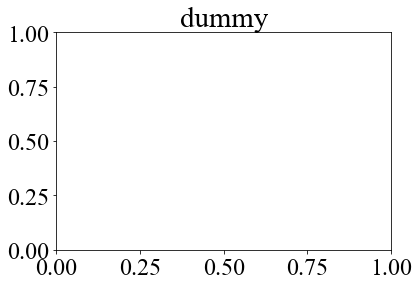

In [5]:
plt.title("dummy")
plt.show()

start Perm
[417121.88045254 271823.79896984 262208.18051267 241751.80571536
 233565.74441784 209342.20318101 209342.20318101 209342.20318101
 209342.20318101 209342.20318101 209342.20318101 201559.39479837
 200681.79581296 200681.79581296 200681.79581296 197899.61191402
 197899.61191402 197899.61191402 197899.61191402 197899.61191402
 197899.61191402 189067.83863303 189067.83863303 189067.83863303
 189067.83863303 186071.42161407 184433.80671694 184433.80671694
 184433.80671694 181233.37659409 177525.21819641 169680.05062389
 169680.05062389 161154.24678017 158896.30566847 157134.03153982
 157134.03153982 154945.67828554 146019.67044507 146019.67044507
 143287.67937679 136644.95505396 133414.59122363 128871.1873117
 121958.43903703 115872.3632528  115872.3632528  115872.3632528
 115872.3632528  112315.89371312 111995.82696112 111094.27704695
 111094.27704695 111094.27704695 111094.27704695 111094.27704695
 108432.51141892 108432.51141892 105360.18583387  97927.99616037
  97927.99616037

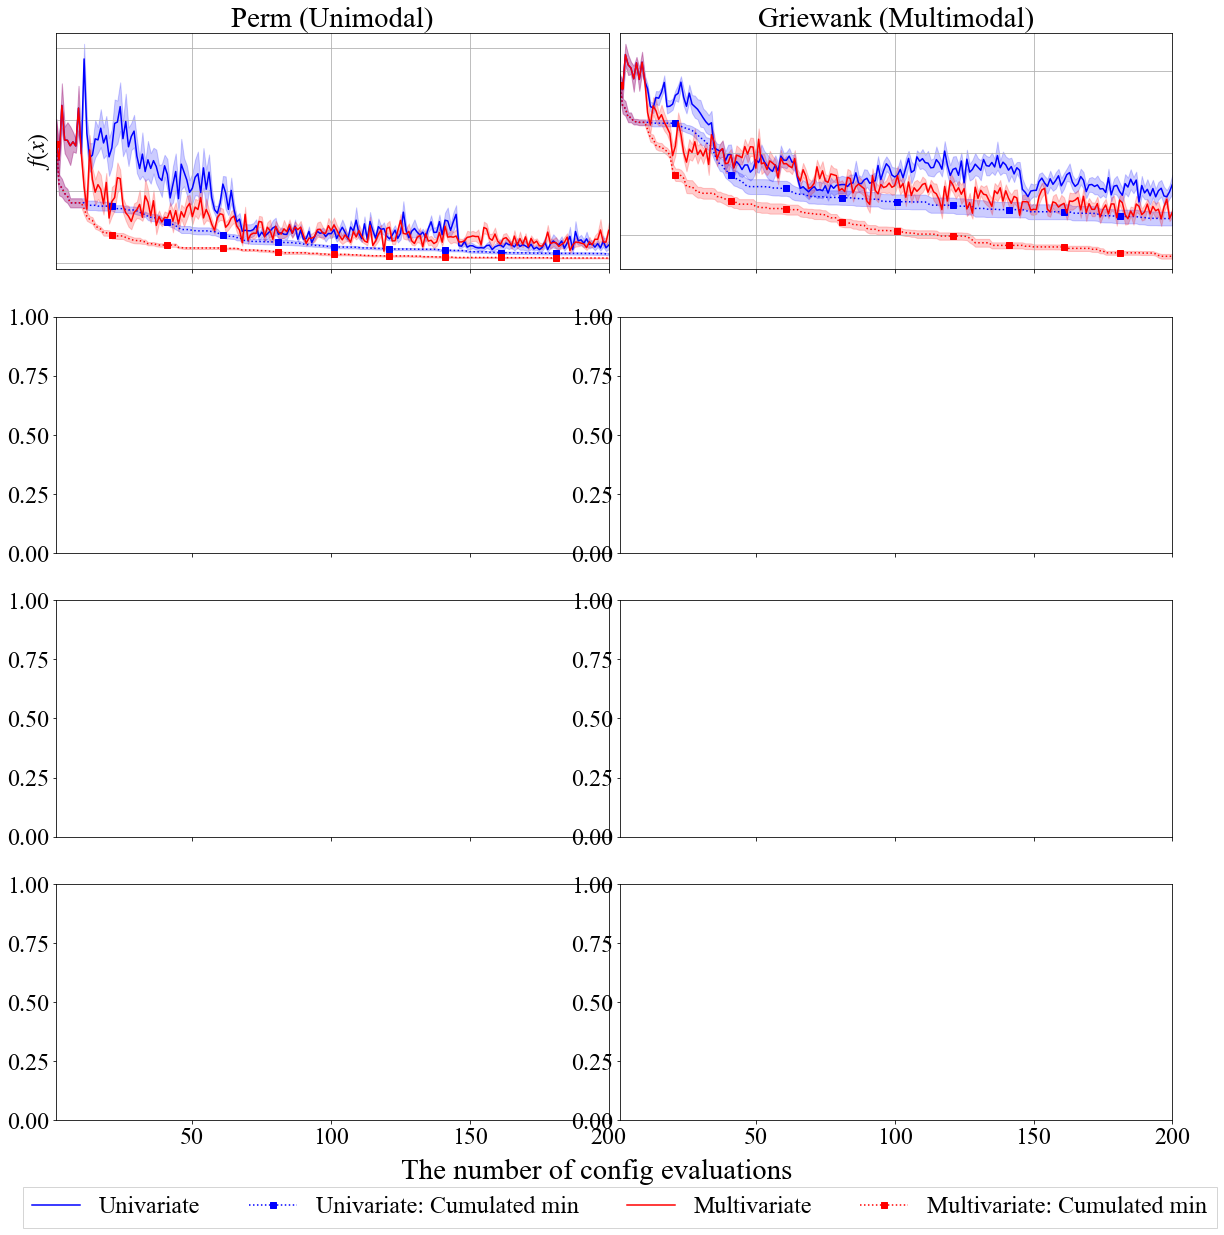

In [28]:
from typing import Dict
from tpe.utils.constants import WeightFuncs, QuantileFunc
import ConfigSpace as CS

n_seeds = 10
DIM = 10
max_evals = 200


def plot(ax: plt.Axes, func):
    config_space = CS.ConfigurationSpace()

    for d in range(DIM):
        config = CS.UniformFloatHyperparameter(f"x{d}", -1, 1)
        config_space.add_hyperparameter(config)

    results = {}
    means = {}
    stes = {}
    cum_means = {}
    cum_stes = {}
    for multivariate in [True, False]:
        results[multivariate] = np.zeros((n_seeds, max_evals))
        for seed in range(n_seeds):
            opt = TPEOptimizer(
                obj_func=func,
                config_space=config_space,
                max_evals=max_evals,
                min_bandwidth_factor=1e-2,
                seed=seed,
                multivariate=multivariate,
            )
            opt.optimize()
            loss_vals = opt.fetch_observations()["loss"]
            results[multivariate][seed] += loss_vals
        else:
            cum_loss_vals = np.minimum.accumulate(results[multivariate], axis=-1)
            cum_means[multivariate] = np.mean(cum_loss_vals, axis=0)
            cum_stes[multivariate] = np.std(cum_loss_vals, axis=0) / np.sqrt(n_seeds)
            means[multivariate] = np.mean(results[multivariate], axis=0)
            stes[multivariate] = np.std(results[multivariate], axis=0) / np.sqrt(n_seeds)

    X = np.arange(max_evals) + 1
    colors = ["blue", "red"]
    lines, labels = [], []
    for color, multivariate in zip(colors, [False, True]):
        m = means[multivariate]
        s = stes[multivariate]
        cm = cum_means[multivariate]
        cs = cum_stes[multivariate]
        label = "Multivariate" if multivariate else "Univariate"

        line, = ax.plot(X, m, color=color)
        lines.append(line)
        labels.append(label)
        ax.fill_between(X, m - s, m + s, color=color, alpha=0.2)

        line, = ax.plot(X, cm, color=color, marker="s", markevery=max_evals//10, linestyle="dotted")
        lines.append(line)
        labels.append(f"{label}: Cumulated min")
        ax.fill_between(X, cm - cs, cm + cs, color=color, alpha=0.2)

    ax.grid()
    ax.set_xlim(1, max_evals)
    return lines, labels


def start():
    fig, axes = plt.subplots(
        figsize=(20, 20),
        ncols=2,
        nrows=4,
        gridspec_kw=dict(
            wspace=0.02,
        ),
        sharex=True,
    )
    TICK_PARAMS = dict(labelleft=False, left=False)

    for ax_in_row, fc_in_row in zip(axes, [
        (KTablet, Ackley),
        (Perm, Griewank),
        (Sphere, Levy),
        (WeightedSphere, Schwefel),
    ]):
        ax, fc = ax_in_row[0], fc_in_row[0]
        print(f"start {fc.name}")
        ax.tick_params(**TICK_PARAMS)
        plot(ax, func=fc.func)
        ax.set_title(f"{fc.name} (Unimodal)")
        ax.set_ylabel("$f(x)$")

        ax, fc = ax_in_row[1], fc_in_row[1]
        print(f"start {fc.name}")
        ax.tick_params(**TICK_PARAMS)
        lines, labels = plot(ax, func=fc.func)
        ax.set_title(f"{fc.name} (Multimodal)")
    else:
        ax = axes[-1][1]
        ax.legend(
            handles=lines,
            labels=labels,
            ncols=len(labels),
            loc="upper center",
            bbox_to_anchor=(0.0, -0.23),
            fancybox=False,
            shadow=False,
        )

    ax = axes[0]
    fig.supxlabel("The number of config evaluations", y=0.08)
    plt.savefig(f"figs/kernel-variate-comparison-{DIM}d.pdf", bbox_inches="tight")


DIM = 10
# start()
DIM = 50
start()

In [29]:
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)


DIM = 50


def func(trial: optuna.Trial):
    eval_config = {
        f"x{d}": trial.suggest_float(f"x{d}", -1, 1)
        for d in range(DIM)
    }
    return Griewank.func(eval_config)


results_multi = []
for i in range(10):
    print(f"The {i}-th Optimization")
    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(multivariate=True)
    )
    study.optimize(func, n_trials=200)
    results_multi.append(np.array([trial.value for trial in study.trials]))


results_uni = []
for i in range(10):
    print(f"The {i}-th Optimization")
    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(multivariate=False)
    )
    study.optimize(func, n_trials=200)
    results_uni.append(np.array([trial.value for trial in study.trials]))

The 0-th Optimization
The 1-th Optimization
The 2-th Optimization
The 3-th Optimization
The 4-th Optimization
The 5-th Optimization
The 6-th Optimization
The 7-th Optimization
The 8-th Optimization
The 9-th Optimization
The 0-th Optimization
The 1-th Optimization
The 2-th Optimization
The 3-th Optimization
The 4-th Optimization
The 5-th Optimization
The 6-th Optimization
The 7-th Optimization
The 8-th Optimization
The 9-th Optimization


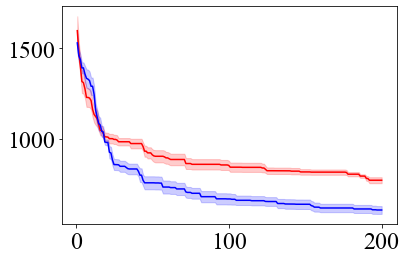

In [30]:
T = np.arange(200) + 1
cum_multi = np.minimum.accumulate(results_multi, axis=-1)
m = np.mean(cum_multi, axis=0)
s = np.std(cum_multi, axis=0) / np.sqrt(10)
plt.plot(T, m, color="red")
plt.fill_between(T, m - s, m + s, color="red", alpha=0.2)

cum_uni = np.minimum.accumulate(results_uni, axis=-1)
m = np.mean(cum_uni, axis=0)
s = np.std(cum_uni, axis=0) / np.sqrt(10)
plt.plot(T, m, color="blue")
plt.fill_between(T, m - s, m + s, color="blue", alpha=0.2)

In [33]:
print(np.mean(cum_multi, axis=0))

[1597.04967715 1479.07213189 1402.22262763 1316.12687387 1309.3128067
 1275.64767838 1227.67429033 1227.67429033 1224.12378693 1210.88108318
 1161.70620877 1133.21407141 1122.09275138 1109.92324025 1078.01530456
 1045.14860057 1044.19977091 1028.29987226 1010.01340551 1009.2457921
 1008.18370275  999.45448625  999.45448625  999.45448625  995.33812284
  995.33812284  991.70814791  982.31659217  982.31659217  982.31659217
  982.31659217  982.31659217  982.31659217  982.31659217  982.31659217
  972.33089431  972.33089431  972.33089431  972.33089431  972.33089431
  972.33089431  972.33089431  972.33089431  955.66914402  930.05619309
  930.05619309  920.8324935   920.8324935   920.8324935   910.31129116
  904.18229851  901.96909598  901.96909598  901.96909598  901.96909598
  901.96909598  901.96909598  898.67905693  893.13751606  893.13751606
  888.69221668  884.2342212   884.2342212   884.2342212   884.2342212
  884.2342212   884.2342212   884.2342212   884.2342212   884.2342212
  884.2342